## Soccer Networks

**Yuval Berman**

Making passing networks out of the events logs stream and evaluating metrics for temporal windows.

In [1]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
# Navigate to the relevant directory
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

In [4]:
# Read in the players (not necessary for global entropy, but helps if wanting to find individual node
# entropy or visualise the passing network)
players = pd.read_json('players.json')
players = players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [5]:
cleaned_events = os.listdir('cleaned_events/')

In [6]:
def initial_df_processing(name):
    
    df = pd.read_json('cleaned_events/'+name)
    
    # Merge the two databases together
    df = df.merge(players, how = 'left', on = 'playerId')
    
    # Let's clean it up a bit and get rid of some unnecessary info so we have just what we need
    df.drop(['passportArea', 'weight', 'firstName','middleName','lastName','currentTeamId',
         'birthDate','height','role','foot','currentNationalTeamId','birthArea','subEventId',
         'id','xStart', 'xEnd', 'yStart', 'yEnd', 'attackMetres'],inplace = True, axis = 1)
    
    return df

In [7]:
def get_game(df, matchId):
    # Finds the match we're after.
    df = df.loc[df['matchId'] == matchId]
    return df

In [8]:
def continuous_time(df):
    # Converts to a continuous 90 min (ie 90*60 = 5400 second) game
    firsthalf = df.loc[df['matchPeriod'] == '1H']
    first_half_length = list(firsthalf['eventSec'])[-1]
    df.loc[ df.matchPeriod == '2H' , 'eventSec'] += first_half_length
    
    #Take out extra time / penalties for the cup games
    df = df.loc[df['matchPeriod'] != 'E1']
    df = df.loc[df['matchPeriod'] != 'E2']
    df = df.loc[df['matchPeriod'] != 'P']
    
    return df

In [9]:
def event_handling(df):
    # Cleans things up based on our interpretation of the events and how they relate to passes. Note the meaning of
    # the events:
    # 1 - duels (this is a hard one to define as it means many different things)
    # 2 - fouls
    # 3 - free kicks / corners (hence we add a node so that it picks these up as the first play in the chain)
    # 4 - keeper leaving their line
    # 7 - Touch, acceletation or clearance (also vague- get rid of touch/acc but keep clearance if its accurate)
    # 8 - Pass - simple/smart, cross (main data we're after for this)
    # 9 - Reflexes / save (however if tagged as inaccurate it means there was a goal)
    # 10- Shot (add a shot node)
    
    df = df.loc[ df['eventId'] != 9]
    df = df.loc[ df['eventId'] != 1]
    df = df.loc[ df['eventId'] != 2]
    df = df.loc[ df['eventId'] != 4]
    df = df.loc[ df['eventId'] != 7]
    df = df.loc[ df['subEventName'] != 'Touch']
    df = df.loc[ df['subEventName'] != 'Acceleration']
    df = df.loc[ (df['subEventName'] != 'Clearance') | (df['Result'] == 'Inaccurate')]
    df = df.drop(df[(df.subEventName == 'Clearance') & (df.Result =='Inaccurate')].index)

    # Create some new columns to see where passes ended up etc
    df["next_event"] = df['eventId'].shift(-1)
    df["next_teamId"] = df["teamId"].shift(-1)
    df["next_player"] = df["shortName"].shift(-1)
    df.loc[ df["next_event"] == 3, 'next_player'] = 0.5
    df.loc[ df["eventId"] == 10, 'next_player'] = 0
    
    return df

In [10]:
def passeslist(df, teamIds):
    
    # Create a Passes column which only has successive events between the same team 
    df = df.drop( df[(df.teamId != df.next_teamId) & (df.next_player != 0)].index)
    df['Passes'] = list(zip(df['shortName'], df['next_player']))
    
    # Get a passes list for each team
    passes = []
    for team in teamIds:    
        temp = df.loc[df['teamId'] == team]
        passes.append(list(temp['Passes']))

    return passes[0], passes[1]

In [11]:
def weighted_passes(passes):
    # Builds a network for the team based on the passes as edges
    n = nx.DiGraph()
    for (i,j) in passes:
        if n.has_edge(i,j):
            n[i][j]['weight'] += 1
        else:
            n.add_edge(i,j, weight = 1)
    
    # Remove node 0.5 as only used to signify start of plays from free kicks / corners
    if 0.5 in n.nodes():
        n.remove_node(0.5)
        
    return n

## Entropy

In [12]:
# Defines a function to calculate the entropy of each node from the transition matrix.
def entropy(row):
    enode = 0
    for item in row:
        if item > 0:
            enode -= item * math.log10(item) # Entropy formula for each node.
    return enode

In [13]:
def find_entropy(net):
    # This function attempts to calculate a team's entropy- i.e. their unpredictability.
    
    n = net
    n = nx.relabel_nodes(n, {0:'ZZ'})
    
    # A stochastic graph gives the probabilities of connections between certain platers       
    prob = nx.stochastic_graph(n)
    
    # Allows us to sort nodes alphabetically so that we can easily remove shot node later
    playerlist = sorted(list(n.nodes()))
    
    # Generates transition matrix
    probmat = nx.adjacency_matrix(prob, nodelist = playerlist)
    probmat = probmat.todense()
    matrix = np.array(probmat) # turns it into numpy array so that we can operate on it

    #entnode =  np.apply_along_axis( entropy, axis=1, arr = matrix ) # calculates entropy for each node
    
    entnode = []
    for row in matrix:
        e = 0
        for item in row:
            if item >0:
                e -= item * math.log10(item)
        entnode.append(e)

    entnode = entnode[:-1] # Gets rid of entropy of shot node

    entrop = sum(entnode)/len(n.nodes()) # Gets the average
        
    return entrop

## Degree & Strength

In [14]:
# out degree
def find_outdeg(net):
    n = net
    # Gives dictionaries of the metrics for each node.
    dic = dict ( n.out_degree() )
    if 0 in dic:
        del dic[0]
    
    met =  sum( list( dic.values() ) )/11
    
    return met

In [15]:
# in degree
def find_indeg(net):
    n = net
    # Gives dictionaries of the metrics for each node.
    dic = dict ( n.in_degree() )
    if 0 in dic:
        del dic[0]
    
    met =  sum( list( dic.values() ) )/11
    
    return met   

In [16]:
# out strength
def find_outstr(net):
    n = net
    # Gives dictionaries of the metrics for each node.
    dic = dict ( n.out_degree(weight = 'weight') )
    if 0 in dic:
        del dic[0]
    
    met =  sum( list( dic.values() ) )/11
    
    return met 

In [17]:
# in strength
def find_instr(net):
    n = net
    # Gives dictionaries of the metrics for each node.
    dic = dict ( n.in_degree(weight = 'weight') )
    if 0 in dic:
        del dic[0]
    
    met =  sum( list( dic.values() ) )/11
    
    return met 

## Betweenness

In [18]:
def find_betweenness(net):
    
    n = net

    bet = nx.betweenness_centrality(n, normalized = False, weight = 'weight') #Just uses nx built ins. # weight?

    # Gets mean of all betweenness values. Shot node will have 0 anyway - it'll never be on the shortest 
    # path.
    betweenness = sum( list( bet.values() ) )/11
    
    return betweenness

In [19]:
def find_nonzero(net):
    
    n = net

    bet = nx.betweenness_centrality(n, normalized = False, weight = 'weight') #Just uses nx built ins. # weight?

    # Find number of players with nonzero betweenness
    nonzero = 0
    for item in list(bet.values()):
        if item > 0:
            nonzero += 1
    
    return nonzero

## Closeness

In [20]:
def find_closeness(net):
    
    n = net

    out_close = nx.algorithms.centrality.closeness_centrality(n.reverse())
    in_close  = nx.algorithms.centrality.closeness_centrality(n)
    # The closeness centrality uses inward distance to a node, not outward. If you want to use outword 
    # distances apply the function to G.reverse(). We want both, with equal weighting, so we add them up.
    close =  np.mean( sum(list( out_close.values() ))/11 + sum(list(in_close.values()))/11 )
    
    return close

## Clustering

In [21]:
def find_clustering(net):
    n = net
    
    cluplayers = nx.clustering(n)
    clus = sum( list(dict(cluplayers).values())) /11
    # clus = nx.algorithms.transitivity(n)
    # Transitivity and clustering are similarly defined but slightly different. Transitivity gives more 
    # weight to higher degree nodes, and clustering gives more weight to lower degree nodes.
    return clus

## Eigenvector Centrality Standard Deviation

In [22]:
def find_evec_std(net):
    
    n = net
    
    # Gets list of every player's eigenvector centrality and takes the standard deviation of that list.
    evec = list(nx.algorithms.centrality.eigenvector_centrality(n,max_iter = 10000).values())
    evecstd = np.std(evec)
    
    return evecstd

## Metrics Function

In [23]:
def metric_calc(net,metric):
    
    if metric == 'passes':
        met = 0
        for item in list(net.edges(data=True)):
            met += item[2]['weight']
    elif metric == 'entropy':
        met = find_entropy(net)
    elif metric == 'outdegree':
        met = find_outdeg(net)
    elif metric == 'indegree':
        met = find_indeg(net)
    elif metric == 'outstrength':
        met = find_outstr(net)
    elif metric == 'instrength':
        met = find_instr(net)
    elif metric == 'betweenness':
        met = find_betweenness(net)
    elif metric == 'nonzero_betweenness':
        met = find_nonzero(net)
    elif metric == 'closeness':
        met = find_closeness(net)
    elif metric == 'clustering':
        met = find_clustering(net)
    elif metric == 'eigenvector_std':
        met = find_evec_std(net)

    return met

## Sliding Windows 

In [24]:
def sliding_window(df,teams, metric):
    # This function iterates sliding 10 minute windows, moving forward by 30 seconds each time and calculate a 
    # team's entropy during that 30 second window

    metrics1 = []
    metrics2 = []
    
    # Iterate sliding windows over the game length
    for i in range(0,int(list(df['eventSec'])[-1])-600,30):
        
        # locate the window in the database
        temp_df = df.loc[df['eventSec'] < i + 600]
        temp_df = temp_df.loc[temp_df['eventSec'] > i]
        
        # Get pass list, create a network, and find that network's entropy
        pass1, pass2 = passeslist(temp_df, teams)

        net1 = weighted_passes(pass1)
        net2 = weighted_passes(pass2)

        # The team's total amount of passes during that 10 minute window 
        tot1 = 0
        tot2 = 0
        for item in list(net1.edges(data=True)):
            tot1 += item[2]['weight']
        for item in list(net2.edges(data=True)):
            tot2 += item[2]['weight']
        
        
        if tot1 > 0:
            met1 = metric_calc(net1, metric)
        else:
            met1 = 0
        if tot2 > 0:
            met2 = metric_calc(net2, metric)
        else:
            met2 = 0
            
        metrics1.append(met1)
        metrics2.append(met2)
    
    return metrics1[:160], metrics2[:160]

In [25]:
def game_iterator(master_df,league, metric):
    
    #Shows what the longest half is and converts to longest possible match
    #longest_game = math.ceil(max(master_df['eventSec'])*2 / 60)
    
    matches = list(set(master_df['matchId']))
    
    mins = []
    for i in range(10,170):
        mins.append(i/2)
        
    results = []

    for m in range(len(matches)):

        print(m)
        match = matches[m]

        df = get_game(master_df,match)
        df = continuous_time(df)
        df = event_handling(df)

        teams = list(set(df['teamId']))

        met1, met2 = sliding_window(df, teams, metric)

        results.append([teams[0], teams[1], match] + met1)
        results.append([teams[1], teams[0], match] + met2)
    
    metric_df = pd.DataFrame(results, columns = ['teamId','Opponent','matchId'] + mins )
    
    return metric_df

In [26]:
# Read in teams df
Teams = pd.read_json('teams.json')
Teams = Teams.rename(columns = {'wyId': 'teamId'})

In [27]:
def main(name, Teams):
    
    df = initial_df_processing(name)
    
    #metric_names = ['passes','entropy','outdegree','indegree','outstrength','instrength','betweenness',
    #             'nonzero_betweenness','closeness','clustering','eigenvector_std']
    metric_names = ['entropy']
    
    
    for metric in metric_names:
        print(metric)
    
        met_df = game_iterator(df, name, metric)
        
        met_df.merge(Teams, how = 'left', on = 'teamId')
        
        if not os.path.exists('revised_'+metric+'_df'):
            os.mkdir('revised_'+metric+'_df')
        met_df.to_json('revised_'+metric+'_df/'+metric+name[14:]) 
        
        allDone()

In [30]:
for name in cleaned_events:
    print(name)
    main(name, Teams)
allDone()

cleaned_events_England.json
entropy
0


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

cleaned_events_France.json
entropy
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268

cleaned_events_Spain.json
entropy
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


cleaned_events_European_Championship.json
entropy
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


cleaned_events_World_Cup.json
entropy
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


cleaned_events_Germany.json
entropy
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
26

cleaned_events_Italy.json
entropy
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


In [ ]:
# Betweenness onwards for Italy

In [33]:
def plotter(df, name):
    teams = list(set(df['teamId']))

    mins = []
    for i in range(10,170):
        mins.append(i/2)

    NUM_COLORS = 20

    cm = plt.get_cmap('tab20')
    fig = plt.figure(figsize = (18,12))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    plt.title('Entropy over the course of a game for teams in the ' + name[11:15] +
              ' league averaged out over their whole season')
    plt.xlabel('Minute of the game')
    plt.ylabel('Team entropy')
    for t in teams:
        se = df.loc[df['teamId'] == t]
        teamname = list(set(se['name']))[0]

        teams_ent = list(se.mean())[3:]

        ax.plot(mins, teams_ent, label = teamname)
    plt.legend()
    plt.show()

In [23]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/entropies_df/')
ent = os.listdir()
ent

['entropies__France.json',
 'entropies__Spain.json',
 'entropies__World_Cup.json',
 'entropies__England.json',
 'entropies__European_Championship.json',
 'entropies__Germany.json',
 'entropies__Italy.json']

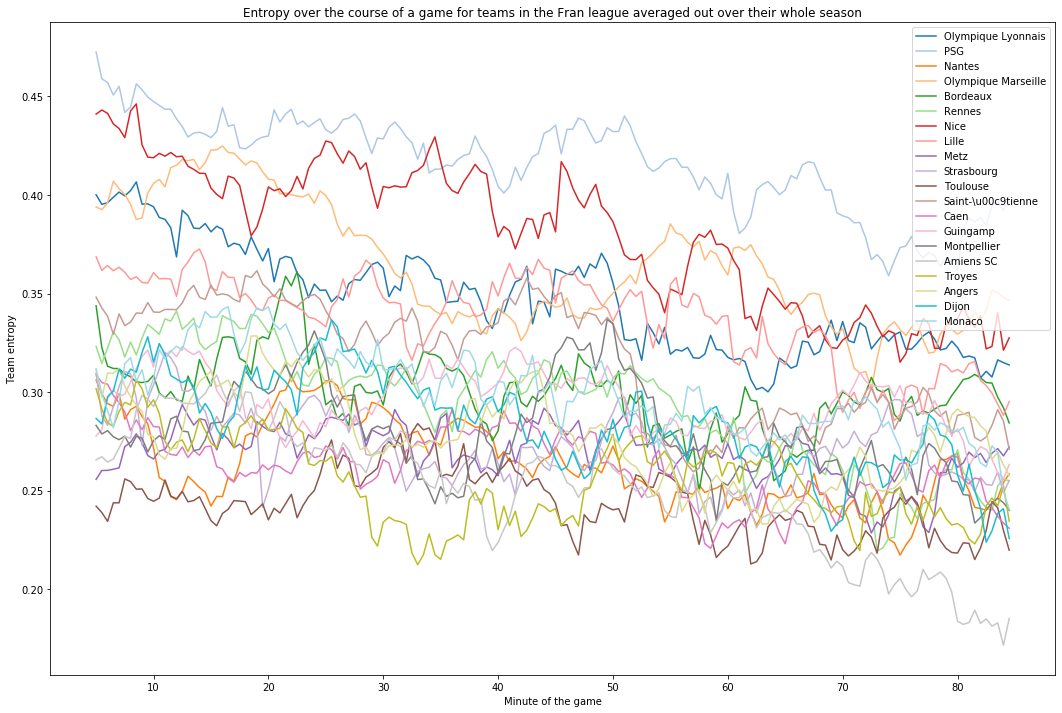

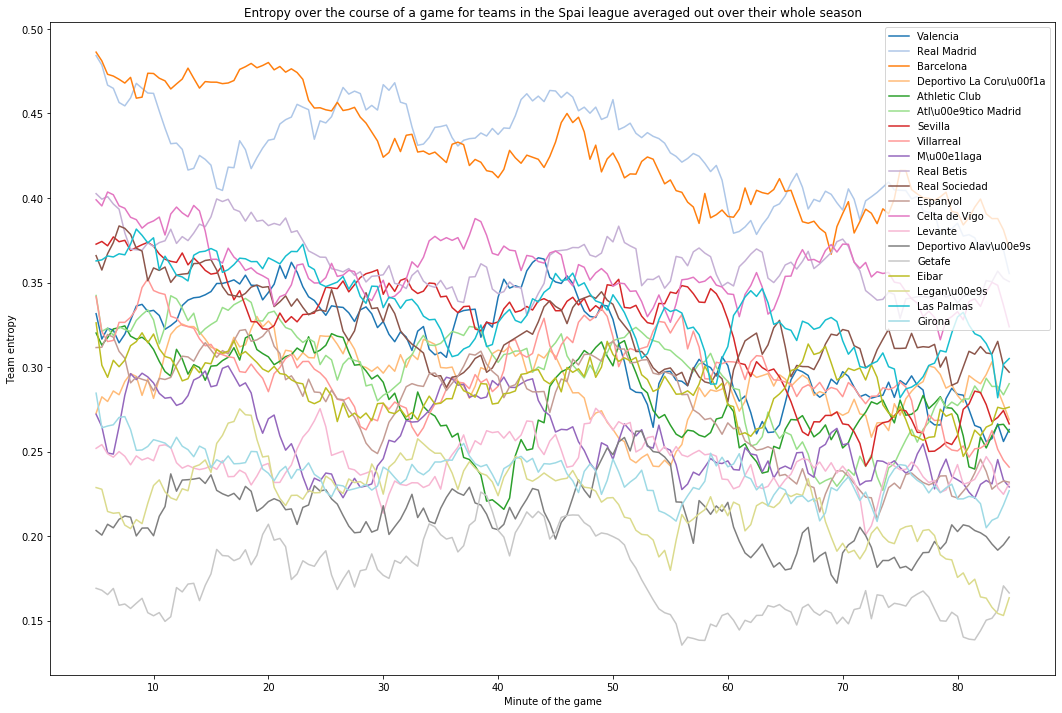

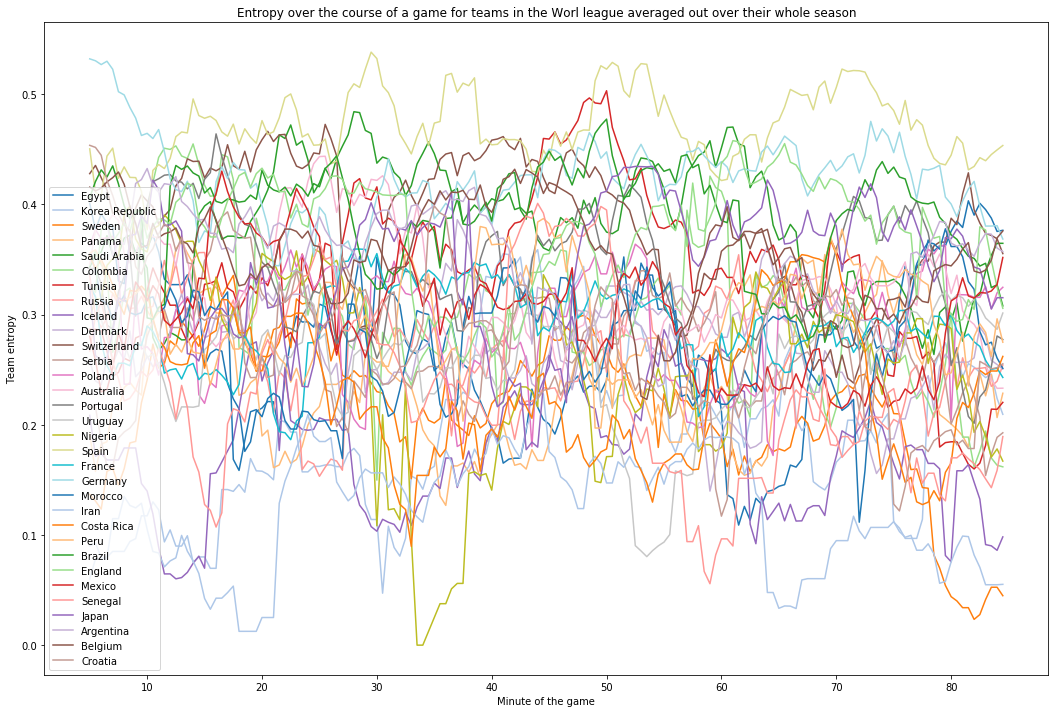

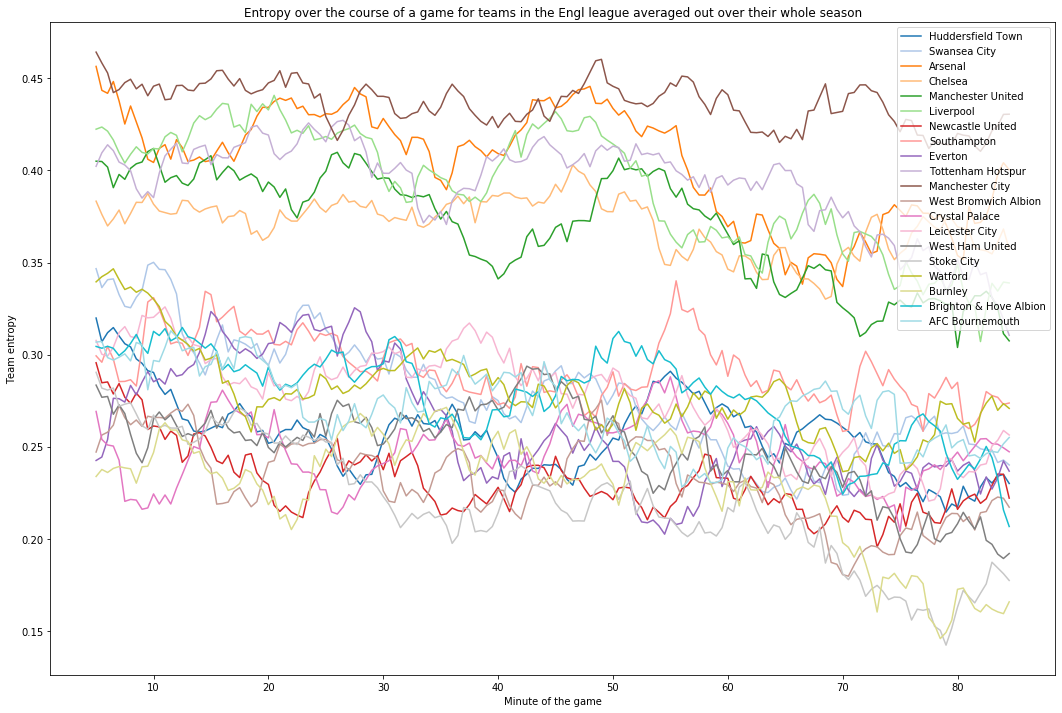

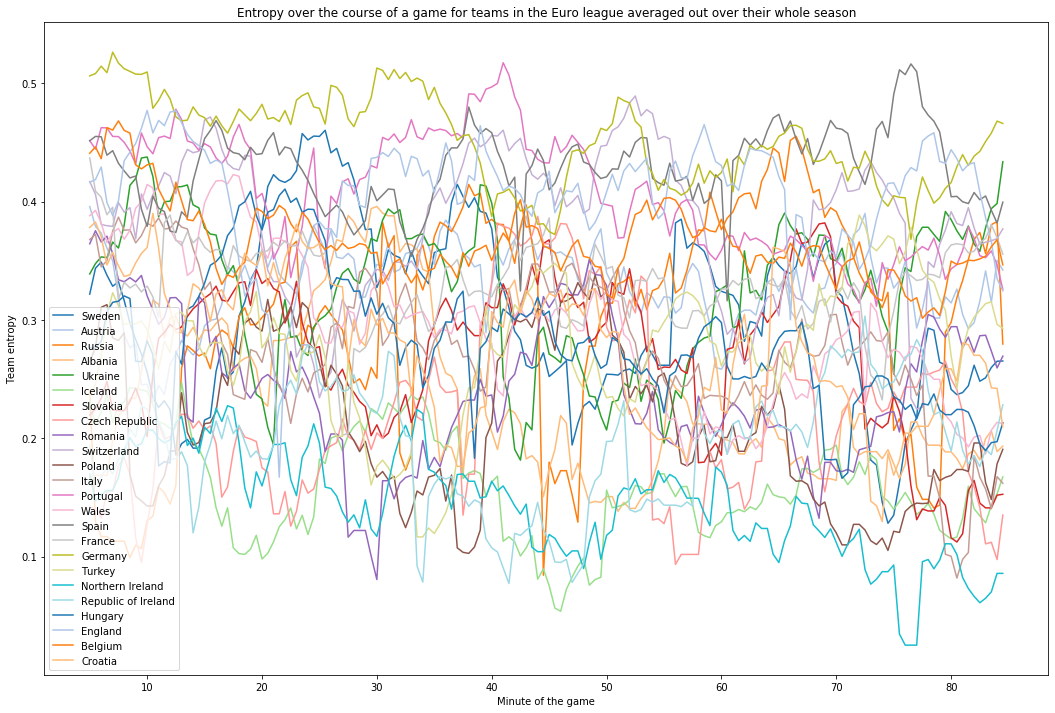

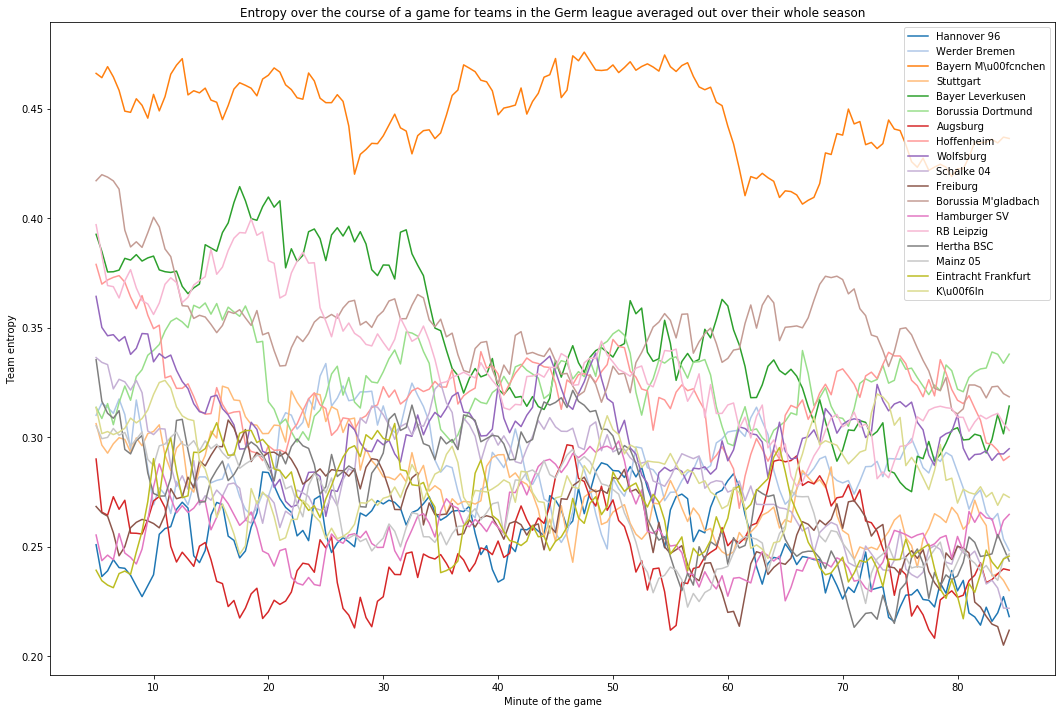

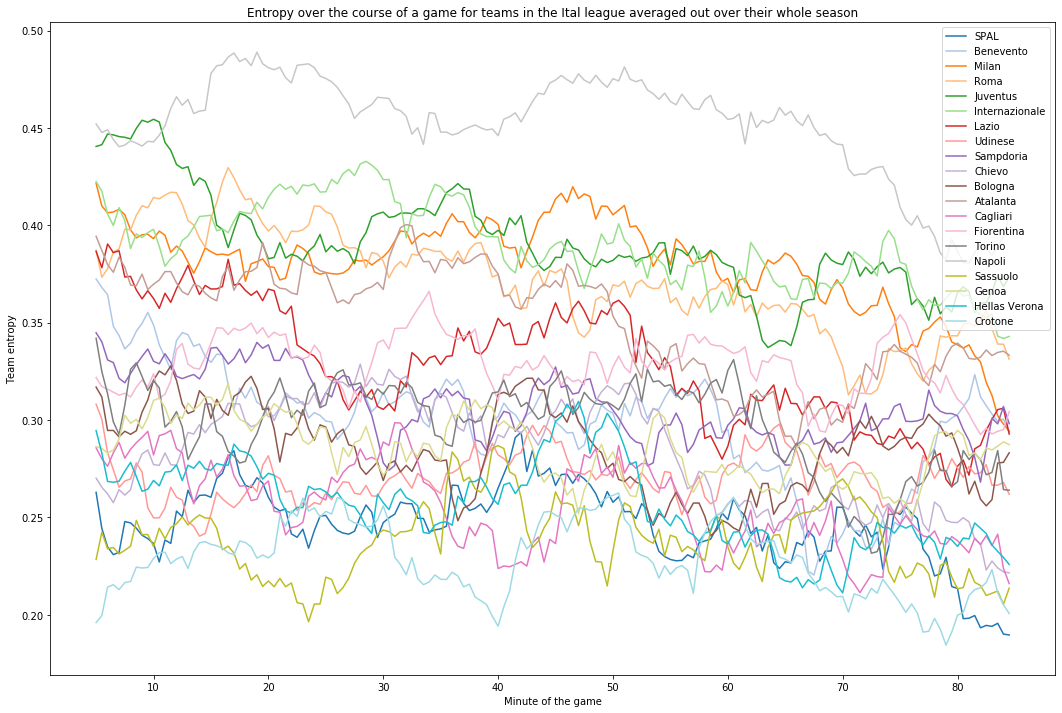

In [25]:
for i in ent:
    df = pd.read_json(i)
    
    plotter(df,i)

In [9]:
# 3-0 el classico - 2565711
# 2-2 el classico - 2565907
df = get_game(df,2565907)
df = df.loc[df['matchPeriod'] == '2H']

Need to understand the data better. Can I find out if a pass was completed, and then the player lost it in the dribble? Can I even abstract it to this level that I ignore so much information? Maybe compare with the footy data and try to spot the key differences. Actually - don't do passes only, keep the data and see if the pass was accurate- as then you can see who received it even if they lost the ball. Then create the next column and then reduce it to passes only.

The code has started to trend in the right direction but there's a lot I need to consider- I need there to be ways for the play to end which aren't a team intercepting the ball (ie a shot). I also need to consider some of the exceptions- for example what I do now takes out 'Acceleration' - but that means it shows as if they never received the ball if they didn't end up passing it. Maybe read more of Jordan's/Decroos GitHub to understand data better, or just keep playing with it and look at what all possible events are so that can make all necessary exceptions!

In [136]:
matches = pd.read_json('matches/matches_Spain.json')

In [145]:
sorted(matches['venue'].unique())

['Camp Nou',
 'Coliseum Alfonso P\\u00e9rez',
 'Estadi Municipal de Montilivi',
 'Estadio Benito Villamar\\u00edn',
 'Estadio Ciudad de Valencia',
 'Estadio La Rosaleda',
 'Estadio Municipal de Anoeta',
 'Estadio Municipal de Butarque',
 'Estadio Municipal de Ipur\\u00faa',
 'Estadio Municipal de Riazor',
 'Estadio Ram\\u00f3n S\\u00e1nchez Pizju\\u00e1n',
 'Estadio Santiago Bernab\\u00e9u',
 'Estadio Wanda Metropolitano',
 'Estadio de Bala\\u00eddos',
 'Estadio de Gran Canaria',
 'Estadio de Mendizorroza',
 'Estadio de Mestalla',
 'Estadio de la Cer\\u00e1mica',
 'RCDE Stadium',
 'San Mam\\u00e9s Barria']

In [149]:
mat = matches.loc[matches['venue'] == 'Estadio Santiago Bernab\\u00e9u']
mat = mat.loc[mat['gameweek'] == 17]
mat

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
213,Played,4406122,17,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2017-12-23 12:00:00,676,Estadio Santiago Bernab\u00e9u,2565711,"Real Madrid - Barcelona, 0 - 3","December 23, 2017 at 1:00:00 PM GMT+1","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795
